In [10]:
!pip install -r requirements.txt

In [11]:
# Bibliothèques standard
import os, requests, zipfile

# Data science et manipulation de données
import pandas as pd, numpy as np, geopandas as gpd

# Accès S3
import s3fs


# Fonctions et styles personnalisés importés de visualisation.py
from visualisation import (
    charte_graphique,
    charte_graphique2,
    charte_graphique3,
    dictionnaire_geo,
    tracer_evolution_taux,
    tracer_evolution_taux_relatif_lisse,
    boxplot_indicateur_par_saison,
    evolution_indicateur_animation,
    animer_evolution_densite,
    evolution_idf_animation,
    get_increase,
    tri_occurrence,
    plot_histogram,
    camembert,
    keywords,
    filter_keyword,
    keywords_occ,
    évolution_indicateur,
    évolution_indicateur,
)

In [51]:
fs = s3fs.S3FileSystem(client_kwargs={"endpoint_url": "https://minio.lab.sspcloud.fr"})
MY_BUCKET = "anhlinh"

FILE_PATH_S3_DEP = f"{MY_BUCKET}/diffusion/df_indicateurs_dep.csv"
with fs.open(FILE_PATH_S3_DEP, "rb") as file_in_dep:
    df_indicateurs_dep = pd.read_csv(file_in_dep)


FILE_PATH_S3_LODA = f"{MY_BUCKET}/diffusion/df_loda.csv"
with fs.open(FILE_PATH_S3_LODA, "rb") as file_in_loda:
    df_loda = pd.read_csv(file_in_loda)

FILE_PATH_S3_NAT = f"{MY_BUCKET}/diffusion/df_indicateurs_nat.csv"
with fs.open(FILE_PATH_S3_NAT, "rb") as file_in_nat:
    df_indicateurs_nat = pd.read_csv(file_in_nat)


In [52]:
df_loda_reg = df_loda.drop([ "Unnamed: 0", "ID", "Date", "Nature", "Etat", "Origine", "Date Publication", "Mois"], axis = 1)
df_loda_reg.head()

,Titre,Année
0,Arrêté du 31 décembre 2008 relatif aux modalit...,2009
1,Arrêté du 31 décembre 2008 portant création d'...,2009
2,Décret n° 2008-1549 du 31 décembre 2008 portan...,2009
3,Arrêté du 31 décembre 2008 relatif aux modalit...,2009
4,Arrêté du 31 décembre 2008 relatif aux modalit...,2009


In [53]:
print(len(df_loda_reg))

df_loda_filtre = filter_keyword(df_loda_reg, r"\bvols?\b")
print(len(df_loda_filtre))


15541
231


In [54]:
df_loda_reg_filtre = df_loda_filtre.groupby("Année").size().reset_index(name="Nombre d'articles")
print(df_loda_reg_filtre)

    Année  Nombre d'articles
0    1997                  5
1    1998                  3
2    1999                  2
3    2000                  2
4    2001                 13
5    2002                  4
6    2004                  9
7    2005                 11
8    2006                  6
9    2008                 30
10   2009                 13
11   2010                  3
12   2011                 15
13   2012                 10
14   2013                 19
15   2014                  8
16   2015                  4
17   2016                  9
18   2017                 13
19   2018                  8
20   2019                  3
21   2020                  5
22   2021                  6
23   2022                 30


In [55]:
df_indicateurs_reg = df_indicateurs_dep.drop([ "Unnamed: 0", "Superficie (km2)", "Nombre" , "Département"], axis = 1)
df_indicateurs_reg = df_indicateurs_reg[df_indicateurs_reg["Indicateur"] == "Vols sans violence"]
df_indicateurs_reg.head()

,Année,Indicateur,Population,Taux (/10 000),Nom Département,Densité
12960,1996,Vols sans violence,499310,242.494643,Ain,86.655675
12961,1996,Vols sans violence,538017,319.878368,Aisne,73.080277
12962,1996,Vols sans violence,349376,280.099377,Allier,47.598910
12963,1996,Vols sans violence,137453,353.066139,Alpes-de-Haute-Provence,19.848809
12964,1996,Vols sans violence,118526,321.954677,Hautes-Alpes,21.359885


In [56]:
df_indicateurs_nat.head()
df_indicateurs_nat_reg = df_indicateurs_nat.loc[: ,["Année", "Taux de pauvreté (%)"]]
df_pauvrete_percent = df_indicateurs_nat_reg.drop_duplicates()
print(df_pauvrete_percent)

     Année  Taux de pauvreté (%)
0     1996                  19.3
12    1997                  18.8
24    1998                  18.4
36    1999                  17.9
48    2000                  18.0
60    2001                  17.2
72    2002                  16.6
84    2003                  18.4
96    2004                  18.0
108   2005                  18.8
120   2006                  18.0
132   2007                  18.2
144   2008                  18.5
156   2009                  19.0
168   2010                  18.9
180   2011                  19.2
192   2012                  20.5
204   2013                  20.0
216   2014                  20.2
228   2015                  19.7
240   2016                  19.7
252   2017                  19.5
264   2018                  19.6
276   2019                  19.7
288   2020                  18.6
300   2021                  20.2
312   2022                  19.3


In [57]:
df_pauvrete_loda_nbr= pd.merge(df_pauvrete_percent, df_loda_reg_filtre, on="Année", how="outer")
df_reg =pd.merge(df_pauvrete_loda_nbr, df_indicateurs_reg, on = "Année", how = "outer")
print(df_reg)

      Année  Taux de pauvreté (%)  Nombre d'articles          Indicateur  \
0      1996                  19.3                NaN  Vols sans violence   
1      1996                  19.3                NaN  Vols sans violence   
2      1996                  19.3                NaN  Vols sans violence   
3      1996                  19.3                NaN  Vols sans violence   
4      1996                  19.3                NaN  Vols sans violence   
...     ...                   ...                ...                 ...   
2587   2022                  19.3               30.0  Vols sans violence   
2588   2022                  19.3               30.0  Vols sans violence   
2589   2022                  19.3               30.0  Vols sans violence   
2590   2022                  19.3               30.0  Vols sans violence   
2591   2022                  19.3               30.0  Vols sans violence   

      Population  Taux (/10 000)          Nom Département      Densité  
0         4993

In [19]:
colonne_a_mettre_en_premier = "Nom Département"
colonnes = [colonne_a_mettre_en_premier] + [col for col in df_reg.columns if col != colonne_a_mettre_en_premier]
df_reg = df_reg[colonnes]
df_reg["Nombre d'articles"] = df_reg["Nombre d'articles"].fillna(0)
df_reg = df_reg.drop(["Indicateur"], axis = 1)
print(df_reg)

              Nom Département  Année  Taux de pauvreté (%)  Nombre d'articles  \
0                         Ain   1996                  19.3                0.0   
1                       Aisne   1996                  19.3                0.0   
2                      Allier   1996                  19.3                0.0   
3     Alpes-de-Haute-Provence   1996                  19.3                0.0   
4                Hautes-Alpes   1996                  19.3                0.0   
...                       ...    ...                   ...                ...   
2587                  Essonne   2022                  19.3               30.0   
2588           Hauts-de-Seine   2022                  19.3               30.0   
2589        Seine-Saint-Denis   2022                  19.3               30.0   
2590             Val-de-Marne   2022                  19.3               30.0   
2591               Val-d'Oise   2022                  19.3               30.0   

      Population  Taux (/10

In [58]:
df_reg = df_reg.set_index(['Nom Département', 'Année'])

In [72]:
pd.set_option('display.max_rows', 10)
df_reg

,,Taux de pauvreté (%),Nombre d'articles,Indicateur,Population,Taux (/10 000),Densité,Articles_lag1,Taux_lag1
Nom Département,Année,,,,,,,,
Ain,1996,19.3,NaN,Vols sans violence,499310,242.494643,86.655675,NaN,NaN
Aisne,1996,19.3,NaN,Vols sans violence,538017,319.878368,73.080277,NaN,NaN
Allier,1996,19.3,NaN,Vols sans violence,349376,280.099377,47.598910,NaN,NaN
Alpes-de-Haute-Provence,1996,19.3,NaN,Vols sans violence,137453,353.066139,19.848809,NaN,NaN
Hautes-Alpes,1996,19.3,NaN,Vols sans violence,118526,321.954677,21.359885,NaN,NaN
...,...,...,...,...,...,...,...,...,...
Essonne,2022,19.3,30.0,Vols sans violence,1319836,172.347170,731.616408,6.0,235.368802
Hauts-de-Seine,2022,19.3,30.0,Vols sans violence,1641277,236.248970,9325.437500,6.0,324.431554
Seine-Saint-Denis,2022,19.3,30.0,Vols sans violence,1679240,255.401253,7115.423729,6.0,367.364428


In [22]:
import pandas as pd
from linearmodels.panel import PanelOLS

# Définir la variable dépendante et les variables explicatives
y = df_reg['Taux (/10 000)']
X = df_reg[["Taux de pauvreté (%)", "Nombre d'articles", "Population", "Densité"]]

# Ajouter une constante pour l'interception
from statsmodels.api import add_constant
X = add_constant(X)

# Modèle de régression pour données de panel
model = PanelOLS(y, X, entity_effects=False)  # entity_effects=True pour inclure les effets fixes des départements

# Ajuster le modèle
results = model.fit()

# Résultats
print(results.summary)

                          PanelOLS Estimation Summary                           
Dep. Variable:         Taux (/10 000)   R-squared:                        0.5256
Estimator:                   PanelOLS   R-squared (Between):              0.6174
No. Observations:                2592   R-squared (Within):               0.3357
Date:                Sat, Dec 28 2024   R-squared (Overall):              0.5256
Time:                        21:24:22   Log-likelihood                -1.531e+04
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      716.50
Entities:                          96   P-value                           0.0000
Avg Obs:                       27.000   Distribution:                  F(4,2587)
Min Obs:                       27.000                                           
Max Obs:                       27.000   F-statistic (robust):             716.50
                            

In [23]:
# Prédictions du modèle
df_reg['Predicted'] = results.predict().fitted_values

In [24]:
df_reg

,,Taux de pauvreté (%),Nombre d'articles,Population,Taux (/10 000),Densité,Predicted
Nom Département,Année,,,,,,
Ain,1996,19.3,0.0,499310,242.494643,86.655675,257.558408
Aisne,1996,19.3,0.0,538017,319.878368,73.080277,262.667897
Allier,1996,19.3,0.0,349376,280.099377,47.598910,236.831284
Alpes-de-Haute-Provence,1996,19.3,0.0,137453,353.066139,19.848809,207.814866
Hautes-Alpes,1996,19.3,0.0,118526,321.954677,21.359885,205.264101
...,...,...,...,...,...,...,...
Essonne,2022,19.3,30.0,1319836,172.347170,731.616408,295.508031
Hauts-de-Seine,2022,19.3,30.0,1641277,236.248970,9325.437500,426.789196
Seine-Saint-Denis,2022,19.3,30.0,1679240,255.401253,7115.423729,409.383369


In [25]:

# Calculer les résidus pour analyse ultérieure si nécessaire
df_reg['Residuals'] = df_reg['Taux (/10 000)'] - df_reg['Predicted']

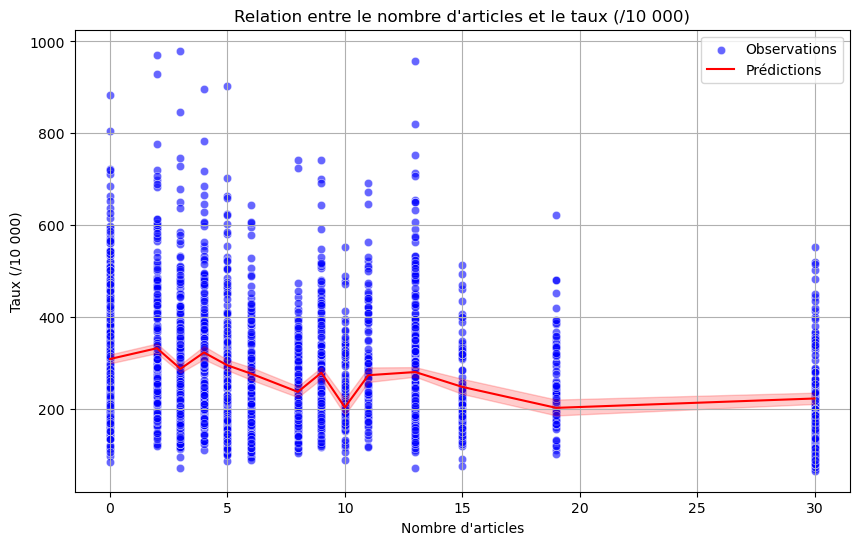

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))

# Points observés
sns.scatterplot(
    x=df_reg['Nombre d\'articles'], 
    y=df_reg['Taux (/10 000)'], 
    color='blue', 
    alpha=0.6, 
    label='Observations'
)

# Ligne de prédictions
sns.lineplot(
    x=df_reg["Nombre d'articles"], 
    y=df_reg['Predicted'], 
    color='red', 
    label='Prédictions'
)

# Ajouter des étiquettes et une légende
plt.title("Relation entre le nombre d'articles et le taux (/10 000)")
plt.xlabel("Nombre d'articles")
plt.ylabel("Taux (/10 000)")
plt.legend()
plt.grid(True)
plt.show()


Regression qui suit : regression avec décalage temporel de 1 an

/tmp/ipykernel_74730/2427915472.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_reg['Articles_lag1'] = df_reg.groupby('Nom Département')["Nombre d'articles"].shift(1)
/tmp/ipykernel_74730/2427915472.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_reg['Taux_lag1'] = df_reg.groupby('Nom Département')['Taux (/10 000)'].shift(1)
/tmp/ipykernel_74730/2427915472.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] 


Résultats de la régression avec lag:
                          PanelOLS Estimation Summary                           
Dep. Variable:         Taux (/10 000)   R-squared:                        0.5212
Estimator:                   PanelOLS   R-squared (Between):              0.6210
No. Observations:                2493   R-squared (Within):               0.3165
Date:                Sat, Dec 28 2024   R-squared (Overall):              0.5212
Time:                        23:52:50   Log-likelihood                 -1.47e+04
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      677.13
Entities:                          96   P-value                           0.0000
Avg Obs:                       25.969   Distribution:                  F(4,2488)
Min Obs:                       25.000                                           
Max Obs:                       26.000   F-statistic (robust):          

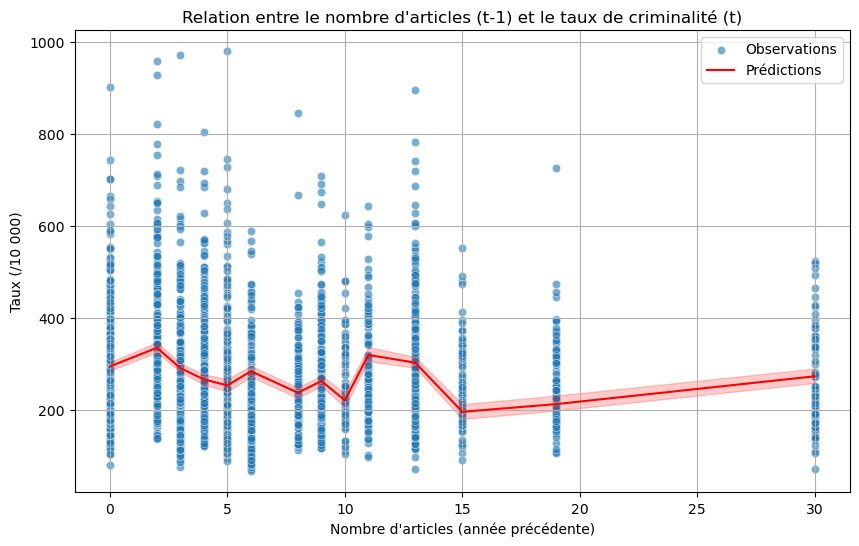

In [ ]:
import pandas as pd
from linearmodels.panel import PanelOLS
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

# Création des variables décalées
df_reg['Articles_lag1'] = df_reg.groupby('Nom Département')["Nombre d'articles"].shift(1)
df_reg['Taux_lag1'] = df_reg.groupby('Nom Département')['Taux (/10 000)'].shift(1)

# Supprimer les lignes avec des NaN créées par le décalage
df_reg["Articles_lag1"] = df_reg["Articles_lag1"].fillna(0)
df_reg["Taux_lag1"] = df_reg["Taux_lag1"].fillna(0)

# Régression
y_lag = df_reg_lag['Taux (/10 000)']
X_lag = df_reg_lag[["Taux de pauvreté (%)", "Articles_lag1", "Population", "Densité"]]
X_lag = sm.add_constant(X_lag)

model_lag = PanelOLS(y_lag, X_lag)
results_lag = model_lag.fit()
print("\nRésultats de la régression avec décalage:")
print(results_lag.summary)

# Visualisation
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_reg_lag, x='Articles_lag1', y='Taux (/10 000)', alpha=0.6, label='Observations')
sns.lineplot(data=df_reg_lag, x='Articles_lag1', y=results_lag.predict().fitted_values, color='red', label='Prédictions')
plt.title("Relation entre le nombre d'articles (t-1) et le taux de criminalité (t)")
plt.xlabel("Nombre d'articles (année précédente)")
plt.ylabel("Taux (/10 000)")
plt.legend()
plt.grid(True)
plt.show()

Régression avec décalage temporel de 2 ans :


Résultats de la régression avec décalage:
                          PanelOLS Estimation Summary                           
Dep. Variable:         Taux (/10 000)   R-squared:                        0.5097
Estimator:                   PanelOLS   R-squared (Between):              0.6174
No. Observations:                2592   R-squared (Within):               0.2871
Date:                Sun, Dec 29 2024   R-squared (Overall):              0.5097
Time:                        00:06:56   Log-likelihood                -1.535e+04
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      672.36
Entities:                          96   P-value                           0.0000
Avg Obs:                       27.000   Distribution:                  F(4,2587)
Min Obs:                       27.000                                           
Max Obs:                       27.000   F-statistic (robust):     

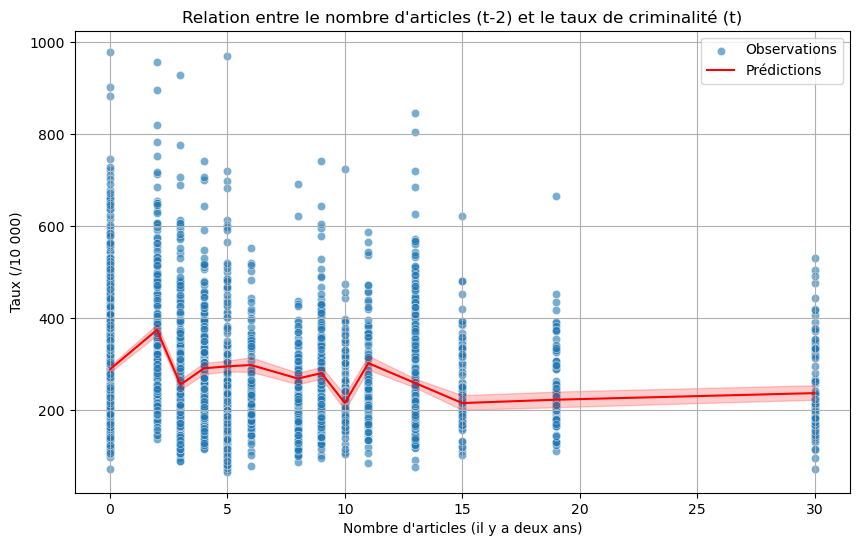

In [73]:
import pandas as pd
from linearmodels.panel import PanelOLS
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

# Création des variables décalées de deux ans
df_reg['Articles_lag2'] = df_reg.groupby('Nom Département')["Nombre d'articles"].shift(2)
df_reg['Taux_lag2'] = df_reg.groupby('Nom Département')['Taux (/10 000)'].shift(2)

# Supprimer les lignes avec des NaN créées par le décalage
df_reg["Articles_lag2"] = df_reg["Articles_lag2"].fillna(0)
df_reg["Taux_lag2"] = df_reg["Taux_lag2"].fillna(0)

# Régression
y_lag = df_reg['Taux (/10 000)']
X_lag = df_reg[["Taux de pauvreté (%)", "Articles_lag2", "Population", "Densité"]]
X_lag = sm.add_constant(X_lag)

model_lag = PanelOLS(y_lag, X_lag)
results_lag = model_lag.fit()
print("\nRésultats de la régression avec décalage:")
print(results_lag.summary)

# Visualisation
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_reg, x='Articles_lag2', y='Taux (/10 000)', alpha=0.6, label='Observations')
sns.lineplot(data=df_reg, x='Articles_lag2', y=results_lag.predict().fitted_values, color='red', label='Prédictions')
plt.title("Relation entre le nombre d'articles (t-2) et le taux de criminalité (t)")
plt.xlabel("Nombre d'articles (il y a deux ans)")
plt.ylabel("Taux (/10 000)")
plt.legend()
plt.grid(True)
plt.show()


Analyse par type de département :

/opt/conda/lib/python3.12/site-packages/linearmodels/panel/model.py:1260: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  super().__init__(dependent, exog, weights=weights, check_rank=check_rank)



Résultats pour les départements à densité Faible:
                          PanelOLS Estimation Summary                           
Dep. Variable:         Taux (/10 000)   R-squared:                        0.3000
Estimator:                   PanelOLS   R-squared (Between):              0.2282
No. Observations:                1148   R-squared (Within):               0.3630
Date:                Sun, Dec 29 2024   R-squared (Overall):              0.3000
Time:                        00:09:48   Log-likelihood                   -6388.2
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      122.48
Entities:                          51   P-value                           0.0000
Avg Obs:                       22.510   Distribution:                  F(4,1143)
Min Obs:                       1.0000                                           
Max Obs:                       24.000   F-statistic (robus

/opt/conda/lib/python3.12/site-packages/linearmodels/panel/model.py:1260: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  super().__init__(dependent, exog, weights=weights, check_rank=check_rank)



Résultats pour les départements à densité Forte:
                          PanelOLS Estimation Summary                           
Dep. Variable:         Taux (/10 000)   R-squared:                        0.5154
Estimator:                   PanelOLS   R-squared (Between):              0.5727
No. Observations:                1156   R-squared (Within):               0.4700
Date:                Sun, Dec 29 2024   R-squared (Overall):              0.5154
Time:                        00:09:48   Log-likelihood                   -6934.0
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      306.02
Entities:                          50   P-value                           0.0000
Avg Obs:                       23.120   Distribution:                  F(4,1151)
Min Obs:                       1.0000                                           
Max Obs:                       24.000   F-statistic (robust

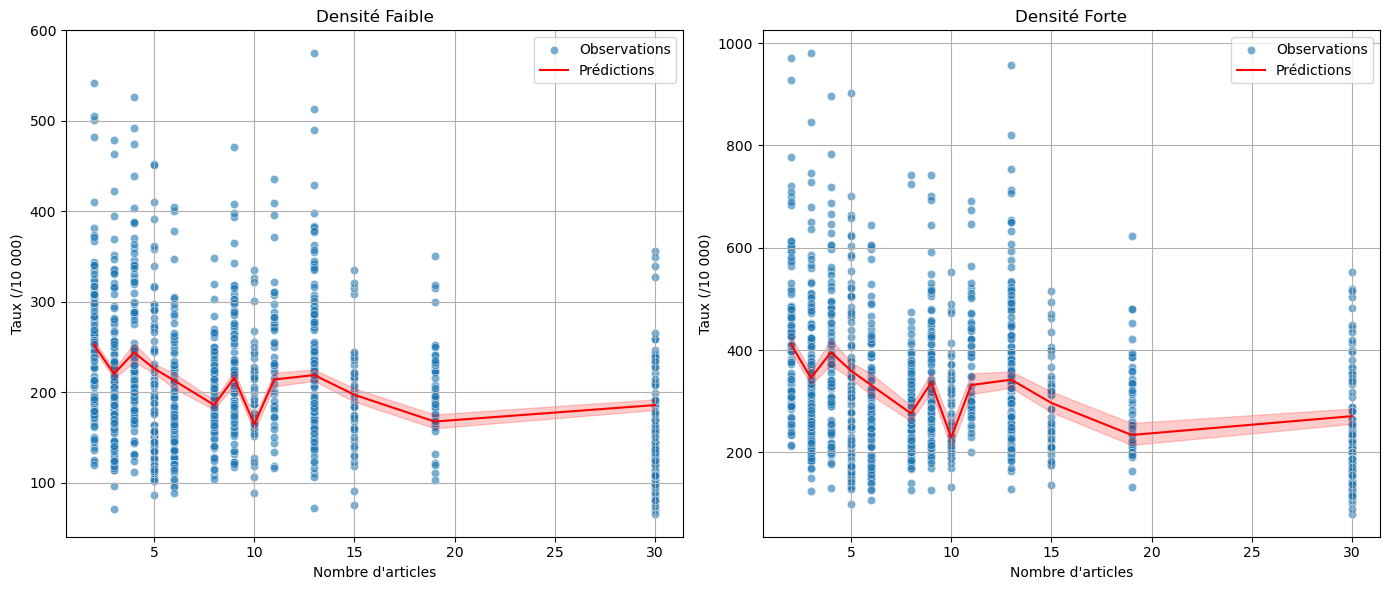

In [74]:
# Création des catégories de densité (2 groupes : Faible et Forte)
df_reg['Densité_cat'] = pd.qcut(df_reg['Densité'], q=2, labels=['Faible', 'Forte'])

# Régressions séparées pour chaque catégorie
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
categories = ['Faible', 'Forte']

for i, cat in enumerate(categories):
    # Filtrer les données
    df_temp = df_reg[df_reg['Densité_cat'] == cat]
    
    # Régression
    y_cat = df_temp['Taux (/10 000)']
    X_cat = df_temp[["Taux de pauvreté (%)", "Nombre d'articles", "Population", "Densité"]]
    X_cat = sm.add_constant(X_cat)
    
    model_cat = PanelOLS(y_cat, X_cat)
    results_cat = model_cat.fit()
    print(f"\nRésultats pour les départements à densité {cat}:")
    print(results_cat.summary)
    
    # Visualisation
    sns.scatterplot(data=df_temp, x="Nombre d'articles", y='Taux (/10 000)', alpha=0.6, ax=axes[i], label='Observations')
    sns.lineplot(data=df_temp, x="Nombre d'articles", y=results_cat.predict().fitted_values, color='red', ax=axes[i], label='Prédictions')
    axes[i].set_title(f"Densité {cat}")
    axes[i].set_xlabel("Nombre d'articles")
    axes[i].set_ylabel("Taux (/10 000)")
    axes[i].grid(True)
    axes[i].legend()

plt.tight_layout()
plt.show()


Régression par sous-périodes :

In [ ]:
'''

# Division en sous-périodes
df_reg_early = df_reg[df_reg['Année'] < 2010]
df_reg_late = df_reg[df_reg['Année'] >= 2010]

# Régression période précoce
y_early = df_reg_early['Taux (/10 000)']
X_early = df_reg_early[["Taux de pauvreté (%)", "Nombre d'articles", "Population", "Densité"]]
X_early = sm.add_constant(X_early)

model_early = PanelOLS(y_early, X_early)
results_early = model_early.fit()
print("\nRésultats pour la période avant 2010:")
print(results_early.summary)

# Régression période tardive
y_late = df_reg_late['Taux (/10 000)']
X_late = df_reg_late[["Taux de pauvreté (%)", "Nombre d'articles", "Population", "Densité"]]
X_late = sm.add_constant(X_late)

model_late = PanelOLS(y_late, X_late)
results_late = model_late.fit()
print("\nRésultats pour la période après 2010:")
print(results_late.summary)

# Visualisation comparative
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Période précoce
sns.scatterplot(data=df_reg_early, x="Nombre d'articles", y='Taux (/10 000)', alpha=0.6, ax=ax1, label='Observations')
sns.lineplot(data=df_reg_early, x="Nombre d'articles", y=results_early.predict().fitted_values, color='red', ax=ax1, label='Prédictions')
ax1.set_title("Avant 2010")
ax1.set_xlabel("Nombre d'articles")
ax1.set_ylabel("Taux (/10 000)")
ax1.grid(True)

# Période tardive
sns.scatterplot(data=df_reg_late, x="Nombre d'articles", y='Taux (/10 000)', alpha=0.6, ax=ax2, label='Observations')
sns.lineplot(data=df_reg_late, x="Nombre d'articles", y=results_late.predict().fitted_values, color='red', ax=ax2, label='Prédictions')
ax2.set_title("Après 2010")
ax2.set_xlabel("Nombre d'articles")
ax2.set_ylabel("Taux (/10 000)")
ax2.grid(True)

plt.tight_layout()
plt.show()
'''

Régression avec effets fixes:

In [ ]:
'''
# Préparation des données pour les effets fixes
y_fe = df_reg['Taux (/10 000)']
X_fe = df_reg[["Taux de pauvreté (%)", "Nombre d'articles", "Population", "Densité"]]
X_fe = sm.add_constant(X_fe)

# Modèle avec effets fixes
model_fe = PanelOLS(y_fe, X_fe, 
                    entity_effects=True,  # effets fixes départementaux
                    time_effects=True)    # effets fixes temporels
results_fe = model_fe.fit()
print("\nRésultats de la régression avec effets fixes:")
print(results_fe.summary)

# Visualisation
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_reg, x="Nombre d'articles", y='Taux (/10 000)', alpha=0.6, label='Observations')
sns.lineplot(data=df_reg, x="Nombre d'articles", y=results_fe.predict().fitted_values, color='red', label='Prédictions')
plt.title("Relation avec effets fixes")
plt.xlabel("Nombre d'articles")
plt.ylabel("Taux (/10 000)")
plt.legend()
plt.grid(True)
plt.show()
'''